# Using akride Python client to interact with Akridata Data Explorer


## Analyze a model's accuracy
Data Explorer provides an interactive experience to evaluate a model's accuracy with IOU and Confidence thresholds, a Confusion matrix and much more.
This notebook shows how the same can be achieved by using the SDK on a sample from the VOC dataset, with ground truth and model predictions provided in a CSV file.
We will see how to:
- Define and ingest a dataset
- Import and view metadata
- Create an Analyze-job with custom IOU & Confidence thresholds
- Display a Confusion Matrix and retrieve examples from off-diagonal cell

Finally, the SDK provides access to the Data Explorer interface for further analysis.

### Prerequisites
- Python version 3.8 or higher is required
- We recommend using a virtual environment to manage your Python dependencies.
- Obtain the API-Key by navigating to the utilities section of the Data Explorer UI and selecting "Get CLI/SDK config. More details can be found in [README.md](../README.md)

### Notebook Setup

`API_KEY`/`SAAS_ENDPOINT` variables must be updated based on the values obtained from SDK Config

By default the the notebook uses a [voc-analyze](../dataset/voc-analyze/) dataset to demonstrate the client usage, but the users are free to customize this by updating `IMAGE_DATA_DIR`,`DATASET_NAME`, `CATALOG_CSV_PATH` variables.


In [1]:

SAAS_ENDPOINT="https://app.akridata.ai"
# Get the sdk config by signing in to Data Explorer UI and navigating to Utilities → Get CLI/SDK config
API_KEY="akridata-apikey"


# Absolute/relative path to the directory which consists of images
IMAGE_DATA_DIR="../dataset/voc-analyze"
# Name of the dataset
DATASET_NAME="voc-analyze"

# Catalog CSV path
CATALOG_CSV_PATH="../dataset/voc-analyze/catalog/voc_catalog.csv"

# Max images to use in the explore job
MAX_IMAGES_IN_JOB=800

### Install akride client

NOTE: We are installing CPU optimized akride SDK for this use case, in case you have a GPU instance available, you can install `akride[gpu]`

In [2]:
import sys

!{sys.executable} -m pip install 'akride[cpu]'
# !{sys.executable} -m pip install 'akride[gpu]' # use this if GPU machine is available

### Initializing akride client

Get the sdk config by signing in to Data Explorer UI and navigating to Utilities → Get CLI/SDK config

In [3]:
from akride import AkriDEClient

# API Key Configurations
sdk_config_dict = {
  "saas_endpoint": SAAS_ENDPOINT,
  "api_key": API_KEY,
  "mode": "saas"
}


client = AkriDEClient(sdk_config_dict=sdk_config_dict)

AkriDEClient initialized


###  Using the client

#### 1. Creating a dataset

Creates a dataset entity on Data Explorer

In [4]:
import random
import string
from akride.core.enums import DataType

# Create a random string of length 5 to enable re-run
rand_prefix = ''.join(random.choices(string.ascii_uppercase, k=5))
if DATASET_NAME == "voc-analyze":
    dataset_name = f"{DATASET_NAME}-{rand_prefix}"
else:
    dataset_name = DATASET_NAME
dataset_spec = {"dataset_name": dataset_name, "data_type":DataType.IMAGE }
dataset = client.create_dataset(spec=dataset_spec )
print(f"Dataset {dataset.get_name()} created successfully with ID {dataset.get_id()}")

Dataset voc-analyze-CISYX created successfully with ID c0d65945-fa42-47c6-880a-910e3bd63963


#### 2. Ingest Dataset

Ingest the image data available locally

In [5]:
import os
import time

task = client.ingest_dataset(
    dataset=dataset,
    data_directory=os.path.abspath(os.path.join(os.getcwd(), IMAGE_DATA_DIR)),
)
while task.has_completed() != True:
    print(f"Current progress:{task.get_progress_info().percent_completed}%")
    time.sleep(5)
if task.has_completed():
    if task.get_error() is None:
        print(f"Data ingestion completed successfully...")
    else:
        print(f"Task failed with error: {task.get_error()}")

Current progress:0.0%
Current progress:0.0%
Current progress:25.0%
Current progress:25.0%


2023-11-15 12:08:33,286,286 | INFO     | data_ingest_filter.py |   Thread-4 |   run_common:224 | Projections df shape: (1, 807, 2)
Projections df shape: (1, 807, 2)
2023-11-15 12:08:33,291,291 | INFO     | data_ingest_filter.py |   Thread-4 |   run_common:225 | Projections arr shape: (807, 1176)
Projections arr shape: (807, 1176)
2023-11-15 12:08:33,307,307 | INFO     | data_ingest_filter.py |   Thread-4 |   run_common:226 | Coreset shape: (1, 242, 3)
Coreset shape: (1, 242, 3)
2023-11-15 12:08:33,310,310 | INFO     | data_ingest_filter.py |   Thread-4 |   run_common:227 | Sketch shape: (1, 24, 1280)
Sketch shape: (1, 24, 1280)


Current progress:25.0%
Current progress:25.0%
Current progress:25.0%
Current progress:100.0%


##### 2.1 Import Catalog Data

We will now import the catalog data that consists of ground truth and and prediction information corresponding the images that were ingested previously



In [6]:
catalog_table_name = "voc_catalog_info"

is_successful: bool = client.import_catalog(dataset=dataset,
                      csv_file_path=os.path.join(os.getcwd(),
                                                 CATALOG_CSV_PATH),
                      file_name_column="file_path(string)",
                      table_name=catalog_table_name,
                      create_view=True)
if is_successful:
    print(f"Catalog imported {catalog_table_name} created successfully, and view {catalog_table_name}_primary_view created")
else:
    print(f"View {catalog_table_name} creation failed.")


Catalog imported voc_catalog_info created successfully, and view voc_catalog_info_primary_view created


##### 2.2 Get Schema Details Of The View
Get the schema details of the view that was created as part of CSV catalog import, this can be used to define the analyze job params

In [9]:
from akride.core.types import CatalogTable

catalog_view = CatalogTable(table_name="voc_catalog_info_primary_view", is_view=True)
client.get_all_columns(dataset=dataset, table=catalog_view)


[Column(name='primary_id', type='INTEGER'),
 Column(name='primary_partition_start', type='BIGINT'),
 Column(name='primary_partition_end', type='BIGINT'),
 Column(name='primary_workflow_id', type='VARCHAR(80)'),
 Column(name='primary_session_id', type='VARCHAR(80)'),
 Column(name='primary_frame_idx_in_blob', type='INTEGER'),
 Column(name='primary_blob_idx_in_partition', type='SMALLINT'),
 Column(name='primary_file_path', type='VARCHAR(512)'),
 Column(name='primary_timestamp', type='DATETIME'),
 Column(name='primary_file_id', type='INTEGER'),
 Column(name='primary_frame_idx_in_file', type='INTEGER'),
 Column(name='primary_file_name', type='VARCHAR(512)'),
 Column(name='primary_total_frames_in_file', type='INTEGER'),
 Column(name='voc_catalog_info_file_path(string)', type='VARCHAR(255)'),
 Column(name='voc_catalog_info_gt_class(string)', type='VARCHAR(255)'),
 Column(name='voc_catalog_info_gt_box(string)', type='VARCHAR(255)'),
 Column(name='voc_catalog_info_pd_class(string)', type='VARCH

#### 3. Create an Analyze Job

In [16]:
from akride.core.enums import EmbedAlgoType, JobType, ClusterAlgoType
from akride.core.types import AnalyzeJobParams, CatalogDetails

# Get the dataset using dataset name
ds = client.get_dataset_by_name(name=dataset_name)
rand_prefix = "".join(random.choices(string.ascii_uppercase, k=5))
job_name = f"{dataset_name}-analyze-{rand_prefix}".upper()
job_spec = client.create_job_spec(
    dataset=ds,
    job_type=JobType.ANALYZE_OBJECT_DETECTION,
    job_name=job_name,
    embed_algo=EmbedAlgoType.UMAP,
    cluster_algo=ClusterAlgoType.HDBSCAN,
    catalog_table=catalog_view,
    max_images=MAX_IMAGES_IN_JOB,
    analyze_params=AnalyzeJobParams(
        catalog_config=CatalogDetails(
            score_column="voc_catalog_info_pd_score(float)",
            ground_truth_class_column="voc_catalog_info_gt_class(string)",
            prediction_class_column="voc_catalog_info_pd_class(string)",
            ground_truth_coordinates_column="voc_catalog_info_gt_box(string)",
            prediction_coordinates_column="voc_catalog_info_pd_box(string)",
        ),
        iou_config=[0, 0.2, 0.4, 0.6, 0.8, 1],
        confidence_config=[0, 0.1, 0.3, 0.5, 0.7, 0.9]
    ),
)

job = client.create_job(spec=job_spec)

In [27]:
while True:
    job = client.get_job_by_name(job_name.upper())
    if job.info.status in ["READY", "FAILED"]:  # type: ignore
        if job.info.status == "READY":
            print(
                f"{job.get_name()} is ready for visualization with {job.info.to_dict()['tunables_default']['max_clusters']} clusters"
            )
        else:
            print(f"{job.get_name()} is in failed state")
        break

    else:
        print("Waiting for job completion")
        time.sleep(5)

VOC-ANALYZE-CISYX-EXPLORE-XOKHJ is ready for visualization with 24 clusters


### 4. Fetch confusion matrix

In [19]:
from akride.core.enums import JobStatisticsContext
from akride.core.types import ConfusionMatrix

cm:ConfusionMatrix = client.get_job_statistics(job=job, context=JobStatisticsContext.CONFUSION_MATRIX) # type: ignore


#### 4.1 Display Confusion Matrix
Confusion matrix helps us visualize absolute and relative model accuracy per class

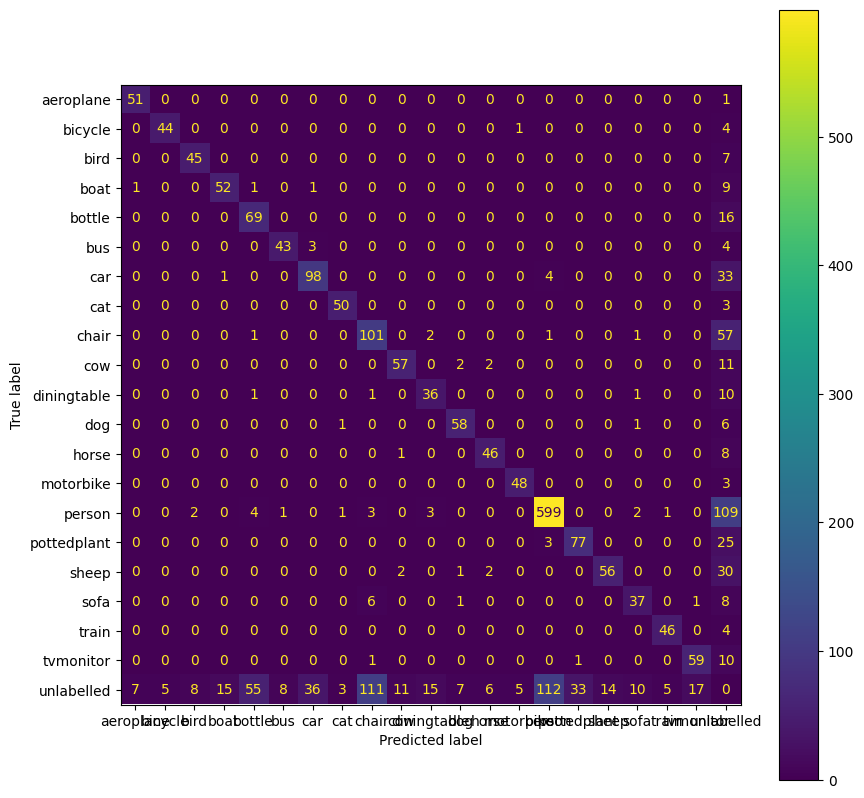

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

disp = ConfusionMatrixDisplay(cm.data, display_labels=cm.labels)
_, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)

In [21]:
import matplotlib.pyplot as plt


# Utility function
def display_grid(nrows, ncols, imgs, size):
    assert len(imgs) <= nrows * ncols
    fig = plt.figure(figsize=(size, size))
    for i, img in enumerate(imgs):
        fig.add_subplot(nrows, ncols, i + 1)
        plt.axis("off")
        plt.tight_layout()
        plt.imshow(img)
    plt.show()

#### 4.2 Get Sample Based On The Confusion Matrix And Display Thumbnails

From the confusion matrix above, there are 6 images of "sofa" that were classified as "chair", Let's fetch those images

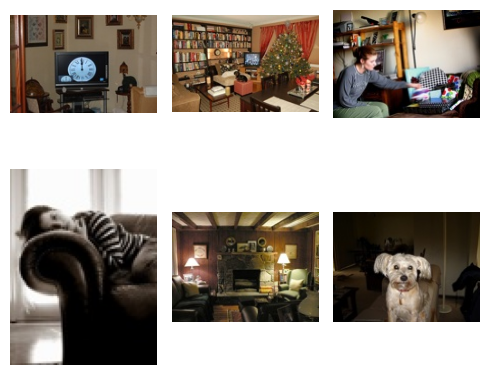

In [29]:
from akride.core.enums import JobContext
spec = {"true_label": "sofa", "predicted_label": "chair"}
samples = client.get_job_samples(
    job, JobContext.CONFUSION_MATRIX_CELL, spec
)

nrows = 2
ncols = 3
max_count = nrows * ncols
samples = samples[:max_count]
imgs = client.get_thumbnail_images(samples)

display_grid(nrows, ncols, imgs, 5)

#### 4.3 Get Catalog Tags For The Samples

In [32]:
from pandas import DataFrame


df: DataFrame = client.get_catalog_tags(samples)
df.head()

,primary_id,primary_partition_start,primary_partition_end,primary_workflow_id,primary_session_id,primary_frame_idx_in_blob,primary_blob_idx_in_partition,primary_file_path,primary_timestamp,primary_file_id,primary_frame_idx_in_file,primary_file_name,primary_total_frames_in_file,voc_catalog_info_file_path(string),voc_catalog_info_gt_class(string),voc_catalog_info_gt_box(string),voc_catalog_info_pd_class(string),voc_catalog_info_pd_box(string),voc_catalog_info_pd_score(float),voc_catalog_info_akd_import_ts
0,None,299999999,293,process_281fc4eac9ad4350b365c14c84457cd0,0,2023-11-15_06-38-22-c0d65945-fa42-47c6-880a-91...,0,2007_004166.jpg,/home/kartik-bhat/source/github/akride-example...,chair,0,2023-11-15 06:39:04.000,1,None,2023-11-15 12:08:50.000,0.424342,2007_004166.jpg,292,"{'x_left': 0.014621039044971654, 'y_top': 0.61...",292
1,None,299999999,293,process_281fc4eac9ad4350b365c14c84457cd0,0,2023-11-15_06-38-22-c0d65945-fa42-47c6-880a-91...,0,2007_004166.jpg,/home/kartik-bhat/source/github/akride-example...,chair,0,2023-11-15 06:39:04.000,1,None,2023-11-15 12:08:50.000,0.375617,2007_004166.jpg,292,"{'x_left': 0.2627881823164912, 'y_top': 0.5484...",292
2,None,299999999,293,process_281fc4eac9ad4350b365c14c84457cd0,0,2023-11-15_06-38-22-c0d65945-fa42-47c6-880a-91...,0,2007_004166.jpg,/home/kartik-bhat/source/github/akride-example...,chair,0,2023-11-15 06:39:04.000,1,None,2023-11-15 12:08:50.000,0.140129,2007_004166.jpg,292,"{'x_left': 0.5246560758856627, 'y_top': 0.7829...",292
3,None,299999999,293,process_281fc4eac9ad4350b365c14c84457cd0,0,2023-11-15_06-38-22-c0d65945-fa42-47c6-880a-91...,0,2007_004166.jpg,/home/kartik-bhat/source/github/akride-example...,chair,0,2023-11-15 06:39:04.000,1,None,2023-11-15 12:08:50.000,0.265384,2007_004166.jpg,292,"{'x_left': 0.6094061270654202, 'y_top': 0.6419...",292
4,None,299999999,293,process_281fc4eac9ad4350b365c14c84457cd0,0,2023-11-15_06-38-22-c0d65945-fa42-47c6-880a-91...,0,2007_004166.jpg,/home/kartik-bhat/source/github/akride-example...,chair,0,2023-11-15 06:39:04.000,1,None,2023-11-15 12:08:50.000,0.293068,2007_004166.jpg,292,"{'x_left': 0.9296704498185561, 'y_top': 0.5931...",292


#### 4.4 Get Job Display Panel URL

For more features that may not be supported in the client at this point, open the Job Display Panel in a browser



In [ ]:
client.get_job_display_panel(job)